In [1]:
# %%configure -f
# {
# "conf":{
#         "spark.pyspark.python": "python3",
#         "spark.pyspark.virtualenv.enabled": "true",
#         "spark.pyspark.virtualenv.type": "native",
#         "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
    
#         "spark.executor.heartbeatInterval":"10800s",
#         "spark.network.timeout":"24h",
    
#         "spark.driver.memory": "1G",
#         "spark.executor.memory": "1G",
#         "spark.executor.cores": "2",
    
#         "spark.app.name":"msds694"
#         }
# }

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1639019290351_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-0>

In [3]:
sc.install_pypi_package("plotly")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
aws-cfn-bootstrap          2.0      
beautifulsoup4             4.9.3    
boto                       2.49.0   
click                      7.1.2    
docutils                   0.14     
jmespath                   0.10.0   
joblib                     1.0.1    
lockfile                   0.11.0   
lxml                       4.6.3    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pip                        9.0.1    
plotly                     5.4.0    
py-dateutil                2.2      
pystache                   0.5.4    
python-daemon              2.2.3    
python37-sagemaker-pyspark 1.4.1    
pytz                       2021.1   
PyYAML                     5.4.1    
regex                      2021.3.17
setuptools                 28.8.0   
simplejson                 3.2.0    
six                        1.13.0   
t

In [5]:
import os
from datetime import datetime
import json
import time

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

By Rachit and Anish

In [6]:
filepath = "s3://distributedproject"
chicago_taxi = sc.textFile(filepath + '/*.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
start = time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#removing headers
cols = chicago_taxi.first()
chicago_taxi = chicago_taxi.filter(lambda x: x != cols)
chicago_taxi = chicago_taxi.map(lambda x: x.split(','))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
col_list = cols.split(',')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def normalize(x, col_list):

    numeric_cols = [
        col_list.index('fare'),
        col_list.index('tips'),
        col_list.index('trip_miles'),
        col_list.index('trip_seconds'),
        col_list.index('tolls'),
        col_list.index('extras'),
        col_list.index('trip_total')
    ]

    for i in range(len(x)):
        if i in numeric_cols:
            if x[i] in ('', 'r', '-'):
                x[i] = 0
            else:
                x[i] = float(x[i])
        elif i == col_list.index('trip_start_timestamp') or i == col_list.index(
                'trip_end_timestamp'):
            if x[i] in ('', 'r', '-'):
                x[i] = '1000-1-1 00:00:00'
                x[i] = datetime.strptime(x[i], '%Y-%m-%d %H:%M:%S')
            else:
                x[i] = datetime.strptime(x[i], '%Y-%m-%d %H:%M:%S')

    return x

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
chicago_taxi_norm = chicago_taxi.map(lambda x: normalize(x, col_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### lat long remapping
by Rachit and Anish

In [12]:
lkp = json.loads(sc.textFile(filepath+'/column_remapping.json').collect()[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
lkp['pickup_latitude'][''] = None
lkp['pickup_longitude'][''] = None
lkp['dropoff_latitude'][''] = None
lkp['dropoff_longitude'][''] = None

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
chicago_taxi_final = chicago_taxi.map(
    lambda x: (x[:col_list.index('pickup_latitude')] + [
        lkp['pickup_latitude'][x[col_list.index('pickup_latitude')]]
    ] + [lkp['pickup_longitude'][x[col_list.index('pickup_longitude')]]] + [
        lkp['dropoff_latitude'][x[col_list.index('dropoff_latitude')]]
    ] + [lkp['dropoff_longitude'][x[col_list.index('dropoff_longitude')]]]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### coordinates to demographics
by Rachit

In [15]:
lkp_coords = json.loads(sc.textFile(filepath+'/coords.json').collect()[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
chicago_tst = chicago_taxi_final.map(lambda x: (x[:-4], lkp_coords[str(
    (x[-4], x[-3]))], lkp_coords[str((x[-2], x[-1]))]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
chicago_final = chicago_tst.map(
    lambda x: (x[0] + [val for val in x[1]] + [val for val in x[2]])).map(lambda x: normalize(x,col_list)).\
                        filter(lambda x : x[-5] is not None and x[-6] is not None
                        and x[13] != 0 and x[13] < 150 and x[4] != 0 and x[4] <= 45).cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
chicago_final.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13726398

## race wise analysis

By Rachit

In [19]:
### Does race imp

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
from collections import Counter

race = [val[0] for val in list(lkp_coords.values())]
Counter(race)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Counter({'Mixed': 343, 'White': 191, 'Black': 125, None: 1})

In [21]:

## Anish added cache 
race_pmt_typ = chicago_final.map(lambda x: (x[-6], x[14]))
# total_race_pmt_typ = dict(race_pmt_typ.countByKey())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# race_pmt_typ.countByValue()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
## analysis 3 payment type
zero_val = 0

race_agg = race_pmt_typ.aggregateByKey(zero_val, lambda x, y: (x + 1),
                                       lambda x, y: (x + y))

race_pmt_typ_agg = race_pmt_typ.map(lambda x: ((x[0],x[1]),0)).\
                                aggregateByKey(zero_val,lambda x,y: (x + 1),
                                lambda x,y: (x + y))

race_pmt_typ_agg = race_pmt_typ_agg.map(lambda x: (x[0], x[1], x[0][0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
temp = dict(race_pmt_typ.countByValue())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# race_pmt_typ.countByValue()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
race_tip = chicago_final.map(lambda x : (x[-6],x[10])).filter(lambda x : x[0] is not None and x[1] != '')\
                                                      .map(lambda x : (x[0],float(x[1])))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
total_race_tip = race_tip.reduceByKey(lambda x, y: x + y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
total_ind_travel = dict(chicago_final.filter(lambda x: x[-6] is not None and x[
    10] != '').map(lambda x: (x[-6])).countByValue())
total_ind_travel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'White': 11101836, 'Mixed': 2542138, 'Black': 82424}

In [29]:
percentage_race_tip = total_race_tip.map(lambda x : (x[0],x[1]/total_ind_travel[x[0]]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
percentage_race_tip_df = percentage_race_tip.toDF()
percentage_race_tip_df.createOrReplaceTempView('percentage_race_tip_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
%%sql -o percentage_race_tip_tab
SELECT * FROM percentage_race_tip_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [32]:
# analysis 4 - tips per race


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Average amount tipped segmented by race of neighbourhood

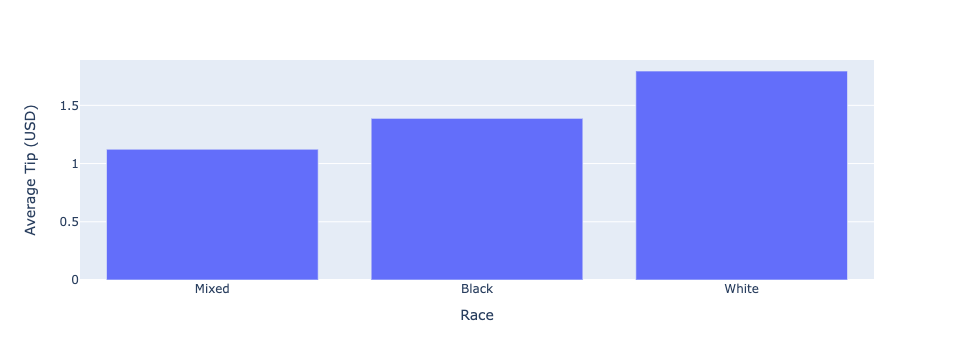

In [33]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

tips_per_race_dict = {
    'Race': list(percentage_race_tip_tab['_1']),
    'Average Tip (USD)': list(percentage_race_tip_tab['_2'])
}
df = pd.DataFrame.from_dict(tips_per_race_dict).sort_values(by='Average Tip (USD)')
df
fig = px.bar(df, x='Race', y='Average Tip (USD)')
fig.show()

## ed wise analysis

By Anish

In [34]:
ed_tvl_tip = dict(
    chicago_final.filter(lambda x: x[-4] is not None and x[10] != '').map(
        lambda x: round(float(x[-4]))).countByValue())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
ed_tot_tip = chicago_final.filter(lambda x : x[-4] is not None and x[10] != '')\
                            .map(lambda x : (round(float(x[-4])),float(x[10])))\
                            .reduceByKey(lambda x,y:x+y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
percentage_ed_tip = ed_tot_tip.map(lambda x : (x[0],x[1]/ed_tvl_tip[x[0]]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
percentage_ed_tip_df = percentage_ed_tip.toDF()
percentage_ed_tip_df.createOrReplaceTempView('percentage_ed_tip_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
%%sql -o percentage_ed_tip_tab
SELECT * FROM percentage_ed_tip_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [39]:
#analysis 5 tips per education level

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Average amount tipped across different neighbourhoods segmented by education

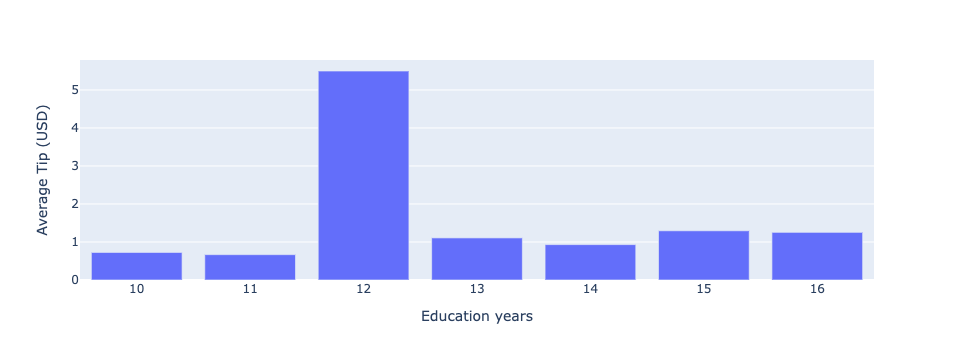

In [40]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

tip_per_ed_dict = {
    'Education years': percentage_ed_tip_tab['_1'],
    'Average Tip (USD)': percentage_ed_tip_tab['_2']
}
df = pd.DataFrame.from_dict(tip_per_ed_dict).sort_values(by='Education years')
df
fig = px.bar(df, x='Education years', y='Average Tip (USD)')
fig.show()

In [41]:
tot_fare_ed = chicago_final.filter(lambda x : x[-4] is not None and x[9] != '')\
                            .map(lambda x : (round(float(x[-4])),round(float(x[9])))).reduceByKey(lambda x,y:x+y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Average total fare across different neighbourhoods segmented by education

In [42]:
tot_fare_ed_df = tot_fare_ed.toDF()
tot_fare_ed_df.createOrReplaceTempView('tot_fare_ed_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
%%sql -o tot_fare_ed_tab
SELECT * FROM tot_fare_ed_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

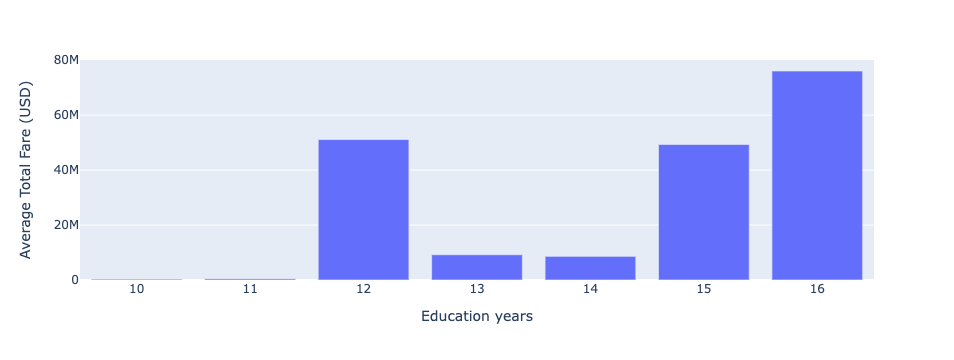

In [44]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

tot_fare_ed_dict = {
    'Education years': list(tot_fare_ed_tab['_1']),
    'Average Total Fare (USD)': list(tot_fare_ed_tab['_2'])
}
df = pd.DataFrame.from_dict(tot_fare_ed_dict).sort_values(by='Education years')
fig = px.bar(df, x='Education years', y='Average Total Fare (USD)')
fig.show()

In [45]:
tot_prsn_fare_ed = dict(chicago_final.filter(lambda x : x[-4] is not None and x[9] != '')\
                            .map(lambda x : (round(float(x[-4])))).countByValue())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
tot_prsn_fare_ed

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{14: 678676, 16: 7005951, 15: 4015228, 13: 604028, 12: 1378008, 11: 26169, 10: 18338}

In [47]:
fare_per_ed = tot_fare_ed.map(lambda x : (x[0],x[1]/tot_prsn_fare_ed[x[0]]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
fare_per_ed_df = fare_per_ed.toDF()
fare_per_ed_df.createOrReplaceTempView('fare_per_ed_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
%%sql -o fare_per_ed_tab
SELECT * FROM fare_per_ed_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

#### Average taxi fare across different neighbourhoods segmented by education

In [50]:
#analysis 6 - fare per education group

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

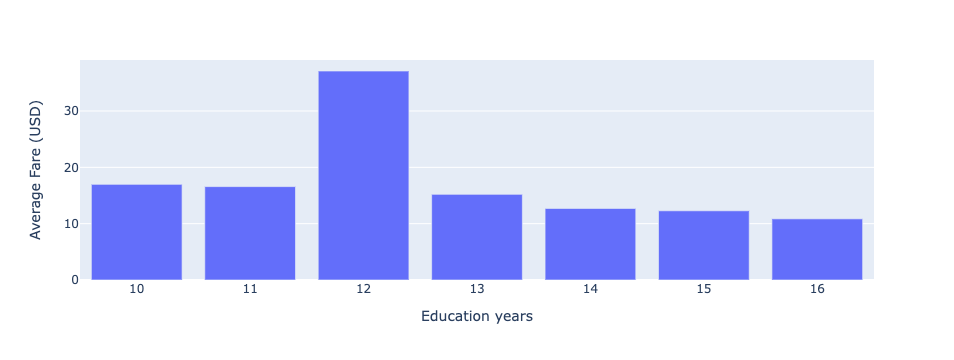

In [51]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

fare_per_ed_dict = {
    'Education years': list(fare_per_ed_tab['_1']),
    'Average Fare (USD)': list(fare_per_ed_tab['_2'])
}
df = pd.DataFrame.from_dict(fare_per_ed_dict).sort_values(by='Education years')
df
fig = px.bar(df, x='Education years', y='Average Fare (USD)')
fig.show()

In [52]:
tip_per_ed = dict(percentage_ed_tip.collect())

tip_fare_percent = fare_per_ed.map(lambda x : (x[0],(tip_per_ed[x[0]]/x[1])*100))




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
#
tip_fare_percent.collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(10, 4.270630421243894), (11, 4.023845196385765), (12, 14.820943204139844), (13, 7.28253601910354), (14, 7.331417592964865), (15, 10.54020765065418), (16, 11.55271871130789)]

In [54]:
tip_fare_percent_df = tip_fare_percent.toDF()
tip_fare_percent_df.createOrReplaceTempView('tip_fare_percent_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
%%sql -o tip_fare_percent_tab
SELECT * FROM tip_fare_percent_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

#### Tip % across different neighbourhoods segmented by education

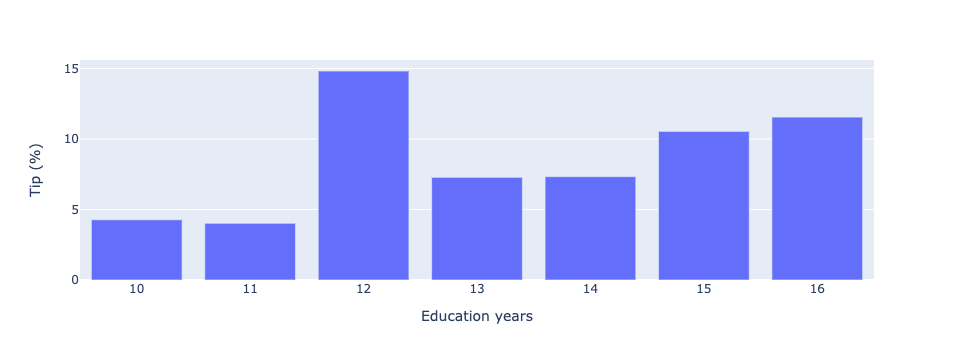

In [56]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

tip_fare_percent_dict = {
    'Education years': list(tip_fare_percent_tab['_1']),
    'Tip (%)': list(tip_fare_percent_tab['_2'])
}

df = pd.DataFrame.from_dict(tip_fare_percent_dict).sort_values(
    by='Education years')

fig = px.bar(df, x='Education years', y='Tip (%)')
fig.show()

## income wise analysis

By Charudatta

In [57]:
### High income

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
### Where do most trips originate from

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
income_anal = chicago_final.map(lambda x: (x[-5])).filter(
    lambda x: x is not None).map(lambda x: (x,1)).groupByKey().mapValues(lambda x: sum(x))

income_sum = sum(income_anal.map(lambda x: x[1]).take(3))

income_anal = income_anal.map(lambda x: (x[0], (x[1]/income_sum)*100))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
income_anal = chicago_final.map(lambda x: (x[-5])).filter(
    lambda x: x is not None).map(lambda x: (x,1)).groupByKey().mapValues(lambda x: sum(x))

income_sum = sum(income_anal.map(lambda x: x[1]).take(3))

income_anal = income_anal.map(lambda x: (x[0], (x[1]/income_sum)*100))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
income_anal_df = income_anal.toDF()
income_anal_df.createOrReplaceTempView('income_anal_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
%%sql -o income_anal_tab
SELECT * FROM income_anal_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

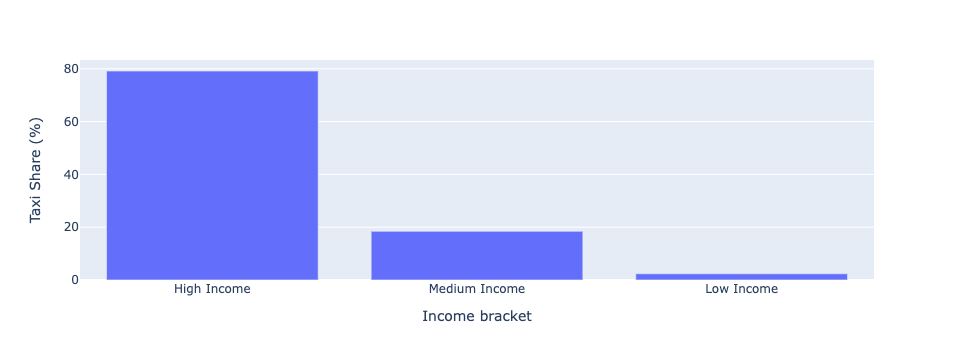

In [63]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd


income_anal_dict = {
    'Income bracket': list(income_anal_tab['_1']),
    'Taxi Share (%)': list(income_anal_tab['_2'])
}

df = pd.DataFrame.from_dict(income_anal_dict)
df['Income bracket'] = df['Income bracket'].apply(lambda x: x.replace('_i',' I'))
df.sort_values(by='Taxi Share (%)', ascending=False, inplace=True)
fig = px.bar(df, x='Income bracket', y='Taxi Share (%)')
fig.show()

### Majority of the trips( ~ 79%) are taken from high income neighbourhoods where median household income is above 70K Dollars


# Analysis of fare by neighborhood

In [64]:
neigh_income_anal = chicago_final.map(lambda x : (x[-5],x[13]/x[4]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
# neigh_income_anal = neigh_income_anal.map(lambda x: (x[0], x[1] / (x[2])))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
neigh_fare_anal = neigh_income_anal.filter(lambda x: x[1] < 30).\
                  groupByKey().mapValues(lambda x: sum(x)/len(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
neigh_fare_anal_df = neigh_fare_anal.toDF()
neigh_fare_anal_df.createOrReplaceTempView('neigh_fare_anal_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
%%sql -o neigh_fare_anal_tab
SELECT * FROM neigh_fare_anal_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

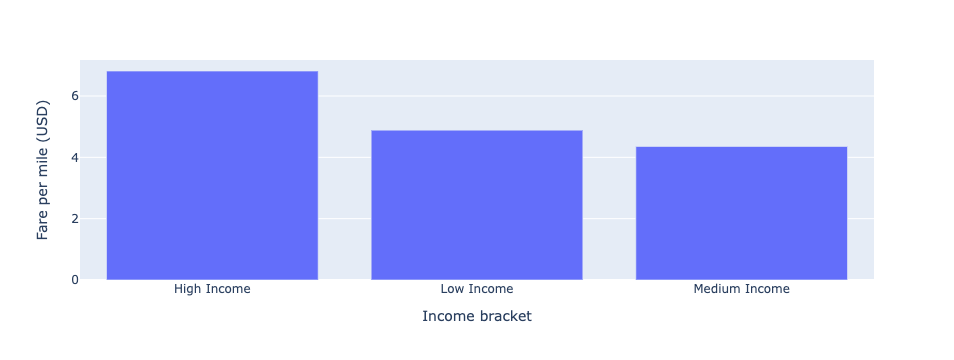

In [69]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

neigh_fare_anal_dict = {
    'Income bracket': list(neigh_fare_anal_tab['_1']),
    'Fare per mile (USD)': list(neigh_fare_anal_tab['_2'])
}

df = pd.DataFrame.from_dict(neigh_fare_anal_dict)
df.sort_values(by='Fare per mile (USD)', ascending=False, inplace=True)
df['Income bracket'] = df['Income bracket'].apply(lambda x: x.replace('_i',' I'))
fig = px.bar(df, x='Income bracket', y='Fare per mile (USD)')
fig.show()

Following code was used for demographic lookup

In [70]:
# with open('coord.txt') as coord:
#     lst = coord.read()
# crd_lkp = eval(lst)

# from tqdm import tqdm
# info= {}
# for val in tqdm(crd_lkp):
#     info[str(val)] = find_region(val[0],val[1])

# info

# with open("coords.json", "w") as outfile:
#     json.dump(info, outfile)

# search = SearchEngine(simple_zipcode=False)
# resp = search.by_coordinates(41.804147373,-87.730828492,returns=1)

# resp[0].population_by_race[0]['values']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Income Wise Analysis                       

#### By Charudatta

In [76]:
relevant_column_idx = {
    'tips': col_list.index('tips'),
    'trip_total': col_list.index('trip_total'),
    'payment_type': col_list.index('payment_type'),
    'pickup_income': 17,
    'drop_income': 20
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
# Aappending tip_frac = tip/fare as a column
def get_tip_frac(row):
    trip_total = row[relevant_column_idx['trip_total']]
    tip = row[relevant_column_idx['tips']]
    if not trip_total:
        return row + [None]
    elif isinstance(tip, (int, float)) and isinstance(trip_total, (int, float)):
        return row + [tip / (trip_total + 0.001)]
    else:
        try:
            trip_total = float(trip_total)
            tip = float(tip)
            if trip_total:
                return row + [tip / (trip_total + 0.001)]
            else:
                return row + [None]
        except:
            return row + [None]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
chicago_final = chicago_final.map(get_tip_frac)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
relevant_column_idx['tip_frac'] = len(chicago_final.take(1)[0]) - 1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
pi = relevant_column_idx['pickup_income']
di = relevant_column_idx['drop_income']
tf = relevant_column_idx['tip_frac']

zero_val = (0, 0)

tip_vs_ic = chicago_final.filter(lambda x: x[pi] is not None)\
                         .filter(lambda x: x[di] is not None)\
                         .filter(lambda x: x[tf] is not None)\
                         .map(lambda x: ((x[pi], x[di]), x[tf]))\
                         .aggregateByKey(zero_val,
                                         lambda a, b: (a[0] + b, a[1] + 1),
                                         lambda a, b: (a[0] + b[0], a[1] + b[1]))

tip_vs_ic_flat = tip_vs_ic.map(lambda x: (x[0][0], x[0][1], x[1][0], x[1][1]))

tip_vs_ic_flat = tip_vs_ic_flat.map(lambda x: (x[0], x[1], x[2]/x[3]))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
tip_vs_ic_flat_df = tip_vs_ic_flat.toDF()
tip_vs_ic_flat_df.createOrReplaceTempView('tip_vs_ic_flat_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
%%sql -o tip_vs_ic_flat_tab
SELECT * FROM tip_vs_ic_flat_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

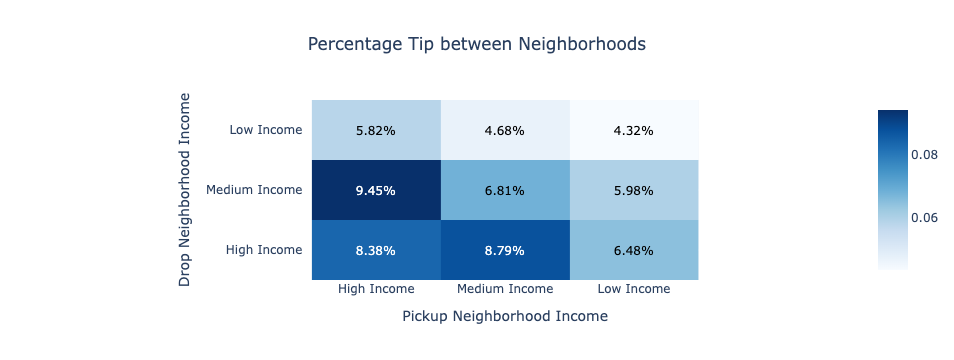

In [83]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

tip_vs_ic_df = pd.DataFrame([tip_vs_ic_flat_tab['_1'],tip_vs_ic_flat_tab['_2'],tip_vs_ic_flat_tab['_3']]).T


tip_vs_ic_df.columns=["Pickup Neighborhood Income","Drop Neighborhood Income","Tip Percent"]
ic_cats = ['High_income', 'Medium_income', 'Low_income']
ic_lol = [[None for _ in range(3)] for _ in range(3)]
for p, pi in enumerate(ic_cats):
    for d, di in enumerate(ic_cats):
        for row in tip_vs_ic_df.iterrows():
#             print(row[1]["Pickup Neighborhood Income"])
            if row[1]["Pickup Neighborhood Income"] == pi and row[1]["Drop Neighborhood Income"] == di:
                ic_lol[p][d] = row[1]["Tip Percent"]

ic_cats_space = ['High Income', 'Medium Income', 'Low Income']
z = ic_lol
x = ic_cats_space
y = ic_cats_space
z_text = [[str(round(100 * num, 2)) + '%' for num in lst] for lst in ic_lol]

fig = ff.create_annotated_heatmap(z,
                                  x=x,
                                  y=y,
                                  annotation_text=z_text,
                                  showscale=True,
                                  colorscale='Blues')
fig.update_xaxes(side="bottom")
fig.update_layout(title='Percentage Tip between Neighborhoods')

fig['layout']['xaxis2'] = {}
fig['layout']['yaxis2'] = {}

# Edit layout for subplots
fig.layout.xaxis.update({'domain': [0.3, .8]})
fig['layout']['title'].update(x=0.5)
fig.layout.yaxis.update({'title': 'Drop Neighborhood Income'})
fig.layout.xaxis.update({'title': 'Pickup Neighborhood Income'})

fig.show()

In [84]:
pi = relevant_column_idx['pickup_income']
pt = relevant_column_idx['payment_type']

pt_vs_ic = chicago_final.filter(lambda x: x[pi] is not None)\
                        .filter(lambda x: x[pt] is not None)\
                        .filter(lambda x: x[pt] != 'Unknown')\
                        .map(lambda x: (x[pi], x[pt]))\
                        .countByValue()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
PaymentType_vs_Income_lol = [[k1, k2, v] for (k1, k2), v in pt_vs_ic.items()]
PaymentType_vs_Income_rdd = sc.parallelize(PaymentType_vs_Income_lol)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
PaymentType_vs_Income_rdd_df = PaymentType_vs_Income_rdd.toDF()
PaymentType_vs_Income_rdd_df.createOrReplaceTempView('PaymentType_vs_Income_rdd_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
%%sql -o PaymentType_vs_Income_rdd_tab
SELECT * FROM PaymentType_vs_Income_rdd_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

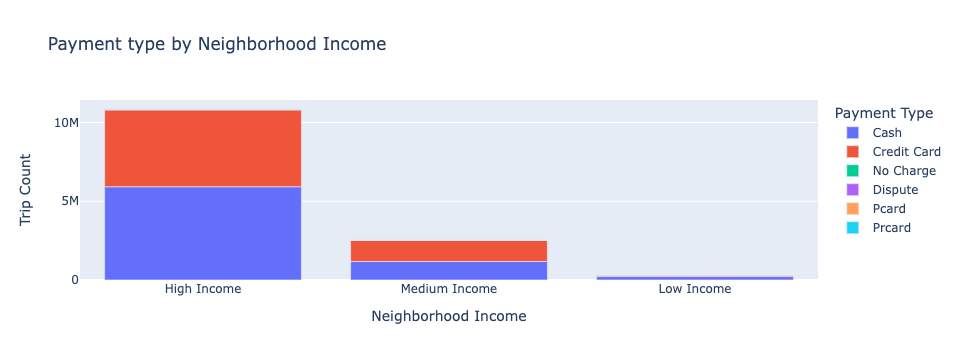

In [88]:
%%local
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

PaymentType_vs_Income_df = pd.DataFrame(data=[PaymentType_vs_Income_rdd_tab['_1'],PaymentType_vs_Income_rdd_tab['_2'],PaymentType_vs_Income_rdd_tab['_3']]).T
PaymentType_vs_Income_df.columns = ['Neighborhood Income', 'Payment Type', 'Trip Count']
PaymentType_vs_Income_df = PaymentType_vs_Income_df.sort_values(by=['Trip Count'], ascending=False)
PaymentType_vs_Income_df['Neighborhood Income'] = PaymentType_vs_Income_df['Neighborhood Income']\
                                                  .apply(lambda x: x.replace('_i', ' I'))


fig = px.bar(PaymentType_vs_Income_df,
             x="Neighborhood Income",
             y="Trip Count",
             color="Payment Type",
             title="Payment type by Neighborhood Income")
fig.show()

In [89]:
end = time.time()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [90]:
print(end - start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

449.7966363430023

In [91]:
sc.stop()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…